# Weather data (2022–2025) for United Kingdom and New Zealand

We are going to have a first approach to the data analysis by looking at the data for weather for both countries United Kingdom (UK) and New Zealand (NZ). 

Data goes from 2022 to 2025 included.

Data is used on a daily basis, not aggregated monthly, to see possible short-time variations. However, an additional year-aggregated visualisation is added for clarity.

# Imports

In [115]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from dotenv import load_dotenv, dotenv_values
import os

from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string
from sqlalchemy import Integer, String, Float, DateTime, Date

# Load table data

In [116]:
# Loading values from .env
config = dotenv_values()

# Define variables for the login
load_dotenv()
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")
schema = os.getenv("DB_SCHEMA")

# PostgreSQL URL creation
url = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

In [117]:
# Create engine
engine = create_engine(url)

# Use explicit connection context

# Load UK data

with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    uk_weather = pd.read_sql(
        text("SELECT * FROM jl_uk_weather"),
        conn
    )

# Load NZ data

with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    nz_temp = pd.read_sql(
        text("SELECT * FROM jl_nz_temp"),
        conn
    )

with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {schema}"))
    nz_rain = pd.read_sql(
        text("SELECT * FROM jl_nz_rain"),
        conn
    )

In [118]:
# Importing UK weather data, checking...
print(uk_weather.head())

         Date  avg_temp_uk  avg_rain_uk
0  2022-01-01        11.80         1.72
1  2022-01-02         9.25         5.54
2  2022-01-03         7.22         5.26
3  2022-01-04         3.00         1.10
4  2022-01-05         1.98         0.00


In [119]:
# Importing NZ temperature data, checking...
print(nz_temp.head())

         Date  1615  24120  41212  41382  5451  Daily mean C
0  2022-01-01  22.7   21.6   20.4   17.8  17.9         20.62
1  2022-01-02  19.9   19.5   24.2   19.1  21.3         20.67
2  2022-01-03  20.9   20.6   21.5   19.3  20.0         20.58
3  2022-01-04  22.3   20.9   21.3   18.6  17.8         20.78
4  2022-01-05  22.9   19.5   17.9   19.1  17.6         19.85


In [120]:
# Importing NZ rainfall data, checking...
print(nz_rain.head())

         Date  1615  24120  41212  41382  5451  Daily mean mm
0  2022-01-01   0.0    0.0    0.0    0.0   0.0            0.0
1  2022-01-02   0.0    0.0    0.0    0.0   0.0            0.0
2  2022-01-03   0.0    0.0    0.0    0.0   0.0            0.0
3  2022-01-04   0.0    0.0    0.0    0.0   0.0            0.0
4  2022-01-05   0.0    0.0    0.0    0.0   0.0            0.0


# Quick checks

In [121]:
# How many rows are empty?

print(
uk_weather.isna().all(axis=1).any(),
nz_temp.isna().all(axis=1).any(),
nz_rain.isna().all(axis=1).any()
)

False False False


In [122]:
# Define new frame with NZ temperature and rainfall only per day

columns_to_exclude = ['1615','24120','41212','41382','5451']
nz_temp_drop = nz_temp.drop(columns=columns_to_exclude)
nz_rain_drop = nz_rain.drop(columns=columns_to_exclude)

# Merge NZ data tables

nz_weather = pd.merge(
    nz_temp_drop,
    nz_rain_drop,
    on="Date",
    how="inner"
)

print(nz_weather)

            Date  Daily mean C  Daily mean mm
0     2022-01-01         20.62           0.00
1     2022-01-02         20.67           0.00
2     2022-01-03         20.58           0.00
3     2022-01-04         20.78           0.00
4     2022-01-05         19.85           0.00
...          ...           ...            ...
1456  2025-12-27         16.25           1.00
1457  2025-12-28         17.48           0.20
1458  2025-12-29         18.88           6.80
1459  2025-12-30         16.95           7.43
1460  2025-12-31         19.35          12.58

[1461 rows x 3 columns]


In [123]:
# General state of the dataframes

print(uk_weather.info())
print('============================================================')
print(nz_weather.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1461 non-null   object 
 1   avg_temp_uk  1461 non-null   float64
 2   avg_rain_uk  1461 non-null   float64
dtypes: float64(2), object(1)
memory usage: 34.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1461 non-null   object 
 1   Daily mean C   1461 non-null   float64
 2   Daily mean mm  1461 non-null   float64
dtypes: float64(2), object(1)
memory usage: 34.4+ KB
None


In [124]:
# Converting date columns to date format

uk_weather['Date'] = pd.to_datetime(uk_weather['Date'], format="%Y-%m-%d")
nz_weather['Date'] = pd.to_datetime(nz_weather['Date'], format="%Y-%m-%d")


In [125]:
# Missing values by column: UK
uk_weather.isna().sum().sort_values(ascending=False)


Date           0
avg_temp_uk    0
avg_rain_uk    0
dtype: int64

In [126]:
# Missing values by column: NZ
nz_weather.isna().sum().sort_values(ascending=False)

Date             0
Daily mean C     0
Daily mean mm    0
dtype: int64

In [127]:
# Basic descriptive stats UK
uk_weather.describe()


,Date,avg_temp_uk,avg_rain_uk
count,1461,1461.000000,1461.000000
mean,2024-01-01 00:00:00,10.632676,2.640712
min,2022-01-01 00:00:00,-2.280000,0.000000
25%,2023-01-01 00:00:00,7.080000,0.140000
50%,2024-01-01 00:00:00,10.660000,1.080000
75%,2024-12-31 00:00:00,14.310000,3.840000
max,2025-12-31 00:00:00,24.380000,29.520000
std,NaN,4.808436,3.601867


In [128]:
# Basic descriptive stats NZ
nz_weather.describe()

,Date,Daily mean C,Daily mean mm
count,1461,1461.000000,1461.000000
mean,2024-01-01 00:00:00,14.640472,3.927940
min,2022-01-01 00:00:00,6.270000,0.000000
25%,2023-01-01 00:00:00,11.600000,0.080000
50%,2024-01-01 00:00:00,14.580000,1.470000
75%,2024-12-31 00:00:00,17.600000,5.050000
max,2025-12-31 00:00:00,24.580000,49.920000
std,NaN,3.741598,6.014147


The mean in both temperature and precipitation indicates that the weather through the year may be similar in both countries in general terms. We need to take into account the seasonality goes the opposite way in both hemispheres. This is consistent with both countries also being in a similar absolute latitude (distance to the equatorial line).

This makes the analysis on both chosen countries adequate for our purpose.

In [129]:
# Unique values

print(uk_weather.nunique())
print(nz_weather.nunique())

Date           1461
avg_temp_uk    1000
avg_rain_uk     430
dtype: int64
Date             1461
Daily mean C      617
Daily mean mm     488
dtype: int64


Row count equals the nunique() values for both tables, therefore no repeated date is appearing in both frames.

# Plots

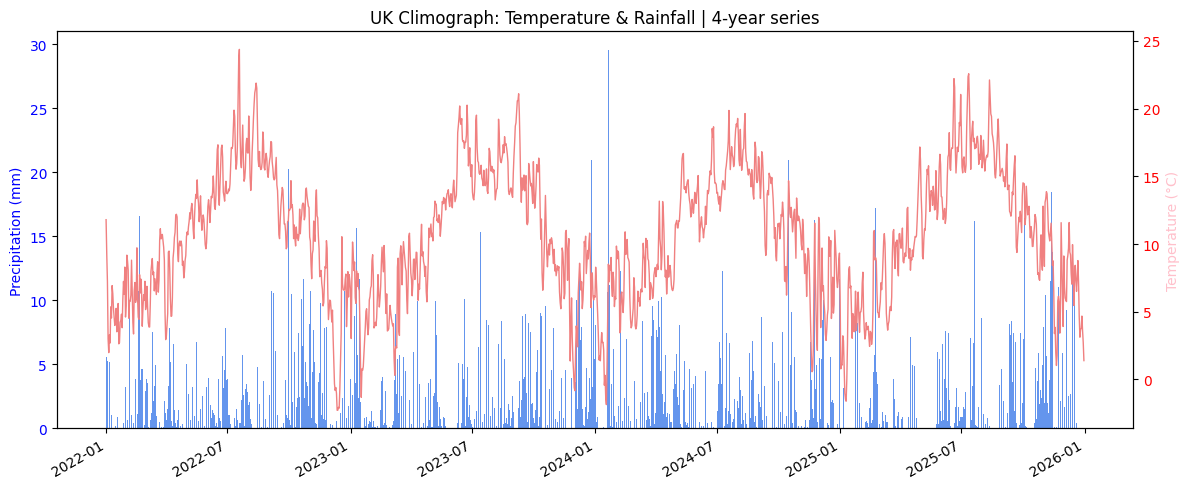

In [130]:

# Ensure date is datetime and sorted
uk_weather = uk_weather.sort_values("Date")

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Rainfall as bars (primary axis) ---
ax1.bar(uk_weather["Date"], uk_weather["avg_rain_uk"], 
        color='cornflowerblue', label='Precipitation (mm)', alpha=1)
ax1.set_ylabel("Precipitation (mm)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# --- Temperature as line (secondary axis) ---
ax2 = ax1.twinx()
ax2.plot(uk_weather["Date"], uk_weather["avg_temp_uk"], 
         color='lightcoral', label='Temperature (°C)', linewidth=1)
ax2.set_ylabel("Temperature (°C)", color='pink')
ax2.tick_params(axis='y', labelcolor='red')

# --- Optional: format x-axis dates ---
fig.autofmt_xdate()  # rotate dates for readability

# --- Titles and legend ---
plt.title("UK Climograph: Temperature & Rainfall | 4-year series")
fig.tight_layout()
plt.show()


Resulting graph is not really that illustrative. For a primary approach, we could aggregate the data per year and do a yearly climograph with these four years data.

In [131]:
# Separate the year from the date
uk_weather['Year'] = uk_weather['Date'].dt.year

# Create month and day field
uk_weather["month_day"] = uk_weather["Date"].dt.strftime("%m/%d")

# Building day and month aggregation
uk_daily = uk_weather.groupby(["month_day"])[["avg_temp_uk", "avg_rain_uk"]].mean().reset_index()

# Ensure date is datetime and sorted
uk_daily = uk_daily.sort_values("month_day")


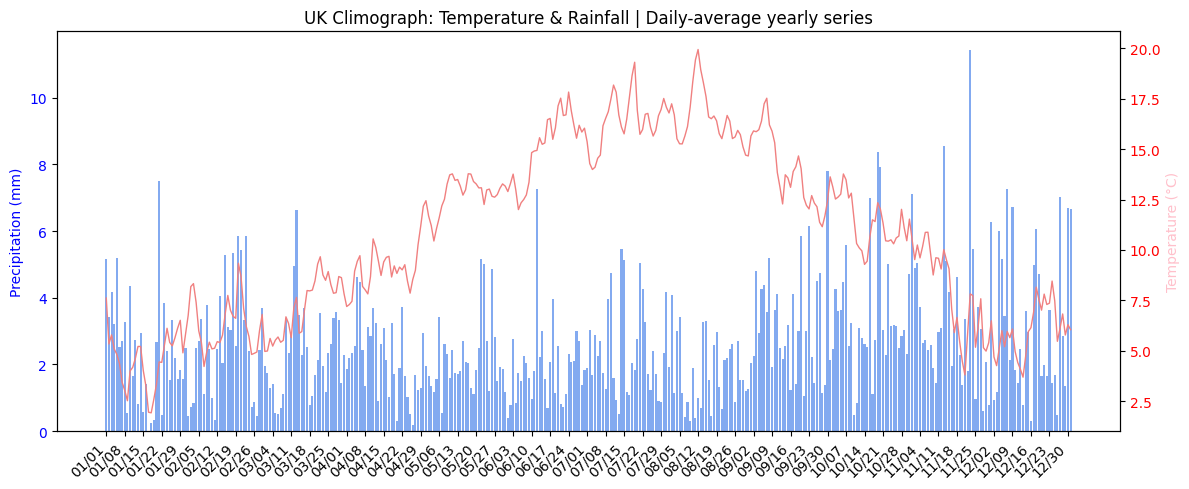

In [132]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Rainfall as bars (primary axis) ---
ax1.bar(uk_daily["month_day"], uk_daily["avg_rain_uk"], 
        color='cornflowerblue', label='Precipitation (mm)', alpha=0.8)
ax1.set_ylabel("Precipitation (mm)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# --- Temperature as line (secondary axis) ---
ax2 = ax1.twinx()
ax2.plot(uk_daily["month_day"], uk_daily["avg_temp_uk"], 
         color='lightcoral', label='Temperature (°C)', linewidth=1)
ax2.set_ylabel("Temperature (°C)", color='pink')
ax2.tick_params(axis='y', labelcolor='red')

# --- Optional: format x-axis dates ---
fig.autofmt_xdate()  # rotate dates for readability

# Display only one date per week
ticks_to_show = uk_daily.index[::7]  # each 7 rows
ax1.set_xticks(ticks_to_show)
ax1.set_xticklabels(uk_daily["month_day"].iloc[::7], rotation=45)


# --- Titles and legend ---
plt.title("UK Climograph: Temperature & Rainfall | Daily-average yearly series")
fig.tight_layout()
plt.show()


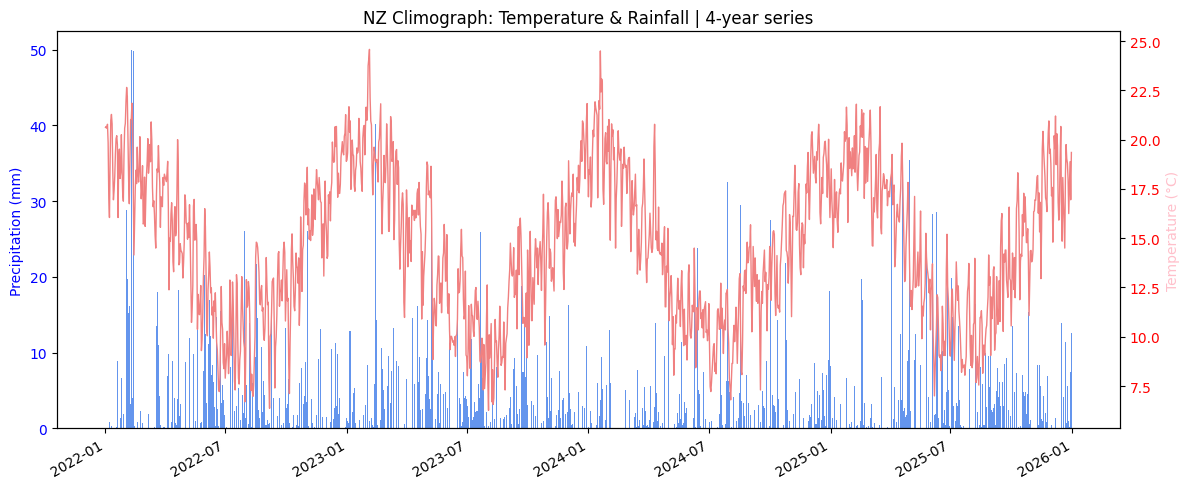

In [133]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Rainfall as bars (primary axis) ---
ax1.bar(nz_weather["Date"], nz_weather["Daily mean mm"], 
        color='cornflowerblue', label='Precipitation (mm)', alpha=1)
ax1.set_ylabel("Precipitation (mm)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# --- Temperature as line (secondary axis) ---
ax2 = ax1.twinx()
ax2.plot(nz_weather["Date"], nz_weather["Daily mean C"], 
         color='lightcoral', label='Temperature (°C)', linewidth=1)
ax2.set_ylabel("Temperature (°C)", color='pink')
ax2.tick_params(axis='y', labelcolor='red')

# --- Optional: format x-axis dates ---
fig.autofmt_xdate()  # rotate dates for readability

# --- Titles and legend ---
plt.title("NZ Climograph: Temperature & Rainfall | 4-year series")
fig.tight_layout()
plt.show()

In [134]:
# Create Year column
nz_weather['Year'] = nz_weather['Date'].dt.year

# Create month and day field
nz_weather["month_day"] = nz_weather["Date"].dt.strftime("%m/%d")

# Building day and month aggregation
nz_daily = nz_weather.groupby(["month_day"])[["Daily mean C", "Daily mean mm"]].mean().reset_index()

# Ensure date is datetime and sorted
nz_daily = nz_daily.sort_values("month_day")

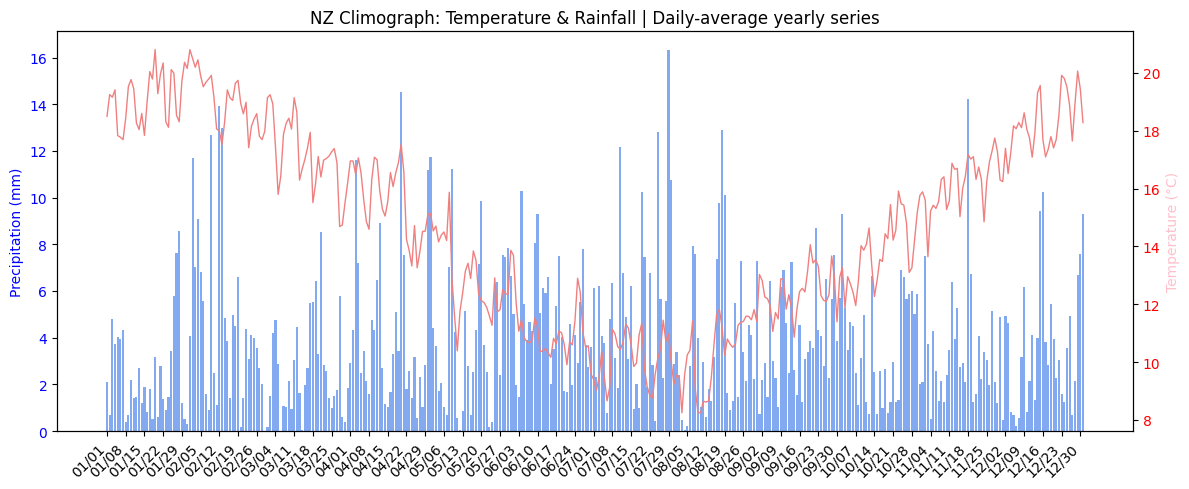

In [135]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Rainfall as bars (primary axis) ---
ax1.bar(nz_daily["month_day"], nz_daily["Daily mean mm"], 
        color='cornflowerblue', label='Precipitation (mm)', alpha=0.8)
ax1.set_ylabel("Precipitation (mm)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# --- Temperature as line (secondary axis) ---
ax2 = ax1.twinx()
ax2.plot(nz_daily["month_day"], nz_daily["Daily mean C"], 
         color='lightcoral', label='Temperature (°C)', linewidth=1)
ax2.set_ylabel("Temperature (°C)", color='pink')
ax2.tick_params(axis='y', labelcolor='red')

# --- Optional: format x-axis dates ---
fig.autofmt_xdate()  # rotate dates for readability

# Display only one date per week
ticks_to_show = uk_daily.index[::7]  # each 7 rows
ax1.set_xticks(ticks_to_show)
ax1.set_xticklabels(uk_daily["month_day"].iloc[::7], rotation=45)


# --- Titles and legend ---
plt.title("NZ Climograph: Temperature & Rainfall | Daily-average yearly series")
fig.tight_layout()
plt.show()
